# Lab Course Machine Learning Exercise Sheet 8 - Arailym Kaiyrova
### Exercise 2: End-to-End Self-Driving via Convolutional Neural Networks

First I tried to follow the code snippet provided in Exercise Sheet 8 to read/show images. However, in that code snippet given for the target value just 'torch.rand(1)' was used, which is a random value, not an actual steering angle from angles.next. That's why, I have slightly modified Dataset() class to be able to retrive both images, and their corresponding steering angles.\
\
In file angles.txt both filenames and angles are stores. So I first read this file, and tried to read the image according to the filename in that file

In [33]:
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, cv2, torch
import numpy as np
import pandas as pd

class Dataset(Dataset): # Inherits from torch.utils.data.Dataset
    def __init__ (self):
        #default directory where data is loaded
        self.filepath='driving_dataset/'
        self.angles = pd.DataFrame(pd.read_csv('driving_dataset/angles.txt', delimiter = " ", header=None))
        self.filenames = list(self.angles.to_records(index=False))
        
    def __len__ (self):
        return len(self.filenames)
    
    def __getitem__ (self,index):
        filename, angle=self.filenames[index]
        img=cv2.imread(self.filepath+filename)
        #Resizingimagesto(66,200)
        resized=cv2.resize(img,(66,200),interpolation=cv2.INTER_AREA)
        
        plt.imshow(resized, cmap='gray' , vmin =0, vmax=255)
        plt.imshow(img, cmap='gray' , vmin =0, vmax=255)
        #return the imagec onverted to a numpy array its corresponding steering angle
        return torch.from_numpy(resized.transpose()).float(),torch.Tensor([angle])

Then the data was separated into train, validation, and test set, and they were loaded into Dataloader. Size of the tes data is 10000, validation data is 1000, and rest is for training. Batch size was selected as 1000, since for smaller sizes it would take too much time to finish on my laptop, that's why I have choosen such large number that is unusual.

(tensor([[[245., 243., 243.,  ..., 111., 112., 114.],
          [243., 243., 242.,  ..., 104., 105., 107.],
          [240., 240., 240.,  ..., 103., 102., 101.],
          ...,
          [179., 180., 180.,  ...,  54.,  53.,  53.],
          [177., 178., 177.,  ...,  52.,  50.,  49.],
          [177., 174., 175.,  ...,  46.,  48.,  51.]],
 
         [[197., 197., 196.,  ..., 117., 118., 121.],
          [199., 200., 202.,  ..., 119., 119., 119.],
          [197., 197., 198.,  ..., 116., 116., 118.],
          ...,
          [134., 134., 134.,  ...,  62.,  62.,  62.],
          [136., 136., 136.,  ...,  60.,  60.,  60.],
          [138., 135., 137.,  ...,  57.,  57.,  57.]],
 
         [[160., 160., 161.,  ..., 129., 130., 132.],
          [166., 162., 159.,  ..., 124., 127., 130.],
          [170., 166., 162.,  ..., 119., 123., 127.],
          ...,
          [ 90.,  86.,  83.,  ...,  63.,  62.,  62.],
          [ 84.,  84.,  85.,  ...,  61.,  61.,  60.],
          [ 77.,  77.,  81.,  .

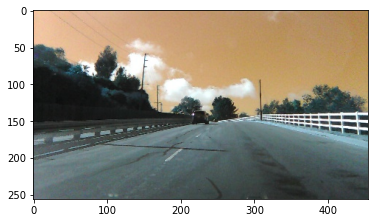

In [34]:
import random
random.seed(10)

data = Dataset()
train_size = len(data) - 10500
train_data, valid_data, test_data = torch.utils.data.random_split(data, [train_size, 500, 10000])

btch_size = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=btch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=btch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=btch_size, shuffle=True)

data[5116]

Next task was to create CNN model according to architecture that was given in paper https://arxiv.org/abs/1604.07316 with 1 normalization, 5 convolution, followed by 3 fully-connected layers, and this SampleNet model was created with comments of image size just to show that its sizes after each layer are exacly same as in the paper.\
\
Then this model was run for one input data only, and below you can see that its tranformed size is exacly same as in the source paper.

The size of the input image:  torch.Size([1, 3, 66, 200])
The size image after normalization:  torch.Size([1, 3, 66, 200])
The size image after first CNN layer:  torch.Size([1, 24, 31, 98])
The size image after second CNN layer:  torch.Size([1, 36, 14, 47])
The size image after third CNN layer:  torch.Size([1, 48, 5, 22])
The size image after fourth CNN layer:  torch.Size([1, 64, 3, 20])
The size image after fifth CNN layer:  torch.Size([1, 64, 1, 18])
The size image after flattening:  torch.Size([1, 1152])
The size image after first fully connected layer:  torch.Size([1, 100])
The size image after second fully connected layer:  torch.Size([1, 50])
The size image after third fully connected layer:  torch.Size([1, 10])


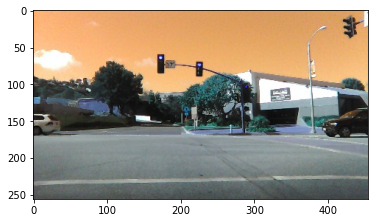

In [35]:
import torch.nn as nn
import torch.nn.functional as F
class SampleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = torch.nn.LayerNorm([3, 66, 200])
        self.conv2 = torch.nn.Conv2d(3,24,5, stride = 2)
        self.conv3 = torch.nn.Conv2d(24,36,5, stride = 2)
        self.conv4 = torch.nn.Conv2d(36,48,5, stride = 2)
        self.conv5 = torch.nn.Conv2d(48,64,3)
        self.conv6 = torch.nn.Conv2d(64,64,3)
        
        self.fc1 = nn.Linear(1152,100)
        self.fc2 = nn.Linear(100, 50)    
        self.fc3 = nn.Linear(50, 10) 
        self.fc4 = nn.Linear(10, 1) 
    
    def forward(self,x):
        print('The size of the input image: ', x.size())
        
        x = F.relu(self.norm(x))
        print('The size image after normalization: ', x.size())       
        x = F.relu(self.conv2(x))
        print('The size image after first CNN layer: ', x.size())        
        x = F.relu(self.conv3(x))
        print('The size image after second CNN layer: ', x.size())       
        x = F.relu(self.conv4(x))
        print('The size image after third CNN layer: ', x.size())        
        x = F.relu(self.conv5(x))
        print('The size image after fourth CNN layer: ', x.size())
        x = F.relu(self.conv6(x))
        print('The size image after fifth CNN layer: ', x.size())
                
        x = x.view(x.shape[0],-1)
        print('The size image after flattening: ', x.size())
        
        x = F.relu(self.fc1(x))
        print('The size image after first fully connected layer: ', x.size())
        x = F.relu(self.fc2(x))
        print('The size image after second fully connected layer: ', x.size())
        x = F.relu(self.fc3(x))
        print('The size image after third fully connected layer: ', x.size())
        x = self.fc4(x)
        return x
    
net=SampleNet()
random_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
optimizer=torch.optim.Adam(net.parameters(),lr=1e-3)
for i, (X, y) in enumerate(random_loader):
    optimizer.zero_grad()
    if i==0: 
        y_pred=net(X)
        break

The final model 'ConvNet' below is exacly same as 'SampleNet' model above, but all the comments were removed, because it would be unneccessary to print the size of the image for input

In [36]:
import torch.nn as nn
import torch.nn.functional as F
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = torch.nn.LayerNorm([3, 66, 200])
        self.conv2 = torch.nn.Conv2d(3,24,5, stride = 2)
        self.conv3 = torch.nn.Conv2d(24,36,5, stride = 2)
        self.conv4 = torch.nn.Conv2d(36,48,5, stride = 2)
        self.conv5 = torch.nn.Conv2d(48,64,3)
        self.conv6 = torch.nn.Conv2d(64,64,3)
        
        self.fc1 = nn.Linear(1152,100)
        self.fc2 = nn.Linear(100, 50)    
        self.fc3 = nn.Linear(50, 10) 
        self.fc4 = nn.Linear(10, 1) 
    
    def forward(self,x):
        x = F.relu(self.norm(x)) 
        
        x = F.relu(self.conv2(x))        
        x = F.relu(self.conv3(x))       
        x = F.relu(self.conv4(x))        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        
        x = x.view(x.shape[0],-1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        x = self.fc4(x)
        return x

The valid model method below calculates the loss for the given data according to given model with parameters.
This method is used for calculating loss for validation data, after the model is trained on given batch of trainset.

In [37]:
def valid_model(net, loader):
    val_loss = 0
    for batch_num, (X,y) in enumerate(loader):
        y_val = net(X)    
        loss = criterion(y_val.squeeze(),y)
        val_loss+=loss.item()
   
    print("Validation loss: ", val_loss/(batch_num+1))
    return val_loss/(batch_num+1)

The below is the training part for CNN model that builded above, using Adam optimizer, which updates the model parameters after each batch of size 1000, also calulates the loss value for validation data with currenly updated model parameters.

In [ ]:
net=ConvNet()

optimizer=torch.optim.Adam(net.parameters(),lr=1e-3)
criterion=torch.nn.MSELoss()

for i, (X, y) in enumerate(train_loader):
    optimizer.zero_grad()
    y_pred=net(X)
    loss=criterion(y_pred.squeeze(),y)
    print("Train loss at", i, "th batch:",loss.item())
    valid_model(net, valid_loader)  
    if i==20: test_model(net, test_loader)
        
    loss.backward()
    optimizer.step()
    
        

Train loss at 0 th batch: 944.810302734375
Validation loss:  843.6868591308594
Train loss at 1 th batch: 1498.30615234375
Validation loss:  895.4291585286459
Train loss at 2 th batch: 1150.2589111328125
Validation loss:  923.0475260416666
Train loss at 3 th batch: 768.365478515625
Validation loss:  960.4044799804688
Train loss at 4 th batch: 1366.211669921875
Validation loss:  943.6158854166666
Train loss at 5 th batch: 1668.750244140625
Validation loss:  829.1661580403646
Train loss at 6 th batch: 839.9943237304688
Validation loss:  855.0835164388021
Train loss at 7 th batch: 532.9075927734375
Validation loss:  916.7502034505209
Train loss at 8 th batch: 428.3477478027344
Validation loss:  997.0798136393229
Train loss at 9 th batch: 1243.756103515625
Validation loss:  874.9648030598959
Train loss at 10 th batch: 1054.087646484375
Validation loss:  910.4729410807291
Train loss at 11 th batch: 1171.4554443359375
Validation loss:  883.9962565104166
Train loss at 12 th batch: 774.27252197

The test model method below calculates the loss, and accuracy of the test dataset after according to the final model parameters when training is finished.

In [39]:
def test_model(net, loader):
    test_loss = 0
    rmse = 0
    for batch_num, (X,y) in enumerate(loader):
        y_test = net(X)
        #loss = torch.sqrt(criterion(y_test.squeeze(),y))
        loss = criterion(y_test.squeeze(),y)
        test_loss+=loss.item()
        
        rmse+=torch.mean((y_test-y)**2)
   
    print("Test loss: ", test_loss/(batch_num+1))
    print("Test Accuracy: ", torch.sqrt(rmse/(batch_num+1)))
    return torch.sqrt(rmse/(batch_num+1))

In [ ]:
test_model(net, test_loader)